# Learning a Non-linear Elastic Law with a Neural Network and Integration into MFront

In this notebook, we define a simple neural network using [jaxmat](https://github.com/bleyerj/jaxmat) and [equinox](https://docs.kidger.site/equinox/) to learn a non-linear elastic behavior. The data are generated using the analytical pseudo-plastic Ramberg-Osgood law. A MFront implementation is used to generate the data. The relation is detailed on the following [page](https://thelfer.github.io/tfel/web/RambergOsgoodNonLinearElasticity.html).

The training set consists of 200 loading paths. Since the constitutive law exhibits strong non-linearity with respect to the von Mises equivalent stress, we deliberately enforce dense sampling of the deviatoric strain space.

We define a standard deviation $\sigma$ such that 99% of the maximum path strains $\varepsilon_f$ remain below the target value:

$$
\sigma = \frac{\varepsilon_{\max}}{\Phi^{-1}(1 - \alpha/2)},
$$

where $\Phi^{-1}$ denotes the inverse cumulative distribution function of the standard normal distribution, and $\alpha = 0.01$.

We randomly sample a final strain point 

$$
\boldsymbol{\varepsilon}_f = \boldsymbol{\varepsilon}_\mathrm{vol} + \boldsymbol{\varepsilon}_\mathrm{dev}
$$ 

by sampling the volumetric space with a standard deviation $\sigma_m^2 = 0.01 \, \sigma$, and the deviatoric part with $\sigma_d^2 = \sigma^2 (1 - \sigma_m^2)$.

We then define a power-law distribution to sample $N$ points along the path, preferentially selecting the initial point:

$$
\sigma[i] = \left(\frac{i}{N-1}\right)^3 \, \varepsilon_f, \quad i = 0, \dots, N-1
$$

We first load the dataset:

In [48]:
import jax
import jax.numpy as jnp
from pathlib import Path
import matplotlib.pyplot as plt
from equinox.nn import MLP
from jaxmat.nn.icnn import ICNN
from jaxmat.utils import partition_by_node_names
from jaxmat.tensors import SymmetricTensor2, main_invariants
import optax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "gpu") # gpu
hdf5_path = Path("./data/dataset_ramberg_osgood_3D_dev.h5")
import jaxmat.materials as jm
import equinox as eqx
from utils import load_from_hdf5
key = jax.random.PRNGKey(42)


# load training data
strain, stress, _, _, _, times, metadata, scalers, config, material_infos = load_from_hdf5(
            hdf5_path, "train"
        )
strain_test, stress_test, _, _, _, times, metadata, scalers, config, material_infos = load_from_hdf5(
            hdf5_path, "test"
        )

times = jnp.array(times)



In [49]:
# normalization
strain /= jnp.mean(scalers["std_strain"]) # use ones scale to conserve isotropy
stress /= jnp.mean(scalers["std_stress"])
strain_test /= jnp.max(scalers["std_strain"]) # use ones scale to conserve isotropy
stress_test /= jnp.max(scalers["std_stress"])


In [50]:
# # Test loi elastique simple
# stress.shape
# epsilon_train = SymmetricTensor2.from_mandel(strain)
# epsilon_test = SymmetricTensor2.from_mandel(strain_test)

# linear = jm.LinearElasticIsotropic(200.0e9 * jnp.mean(scalers["std_strain"]) / jnp.mean(scalers["std_stress"]), 0.3)

# # f_stress = lambda epsilon : jnp.sum(epsilon * epsilon) * epsilon # linear.C @ epsilon + 
# # epsilon_train
# # stress_train = jax.vmap(jax.vmap(f_stress, in_axes=0), in_axes=0)(epsilon_train)
# # stress_test = jax.vmap(jax.vmap(f_stress, in_axes=0), in_axes=0)(epsilon_test)

# # stress = SymmetricTensor2.to_mandel(SymmetricTensor2(tensor=stress_train))

# norm = jnp.max(stress)
# stress /= norm
# stress_test /= norm
# epsilon_train = SymmetricTensor2(tensor=epsilon_train._tensor.reshape(-1, 3,3))
# epsilon_test = SymmetricTensor2(tensor=epsilon_test._tensor.reshape(-1, 3,3))
# stress_train = SymmetricTensor2(tensor=stress_train.reshape(-1, 3,3))
# stress_test = SymmetricTensor2(tensor=stress_test.reshape(-1, 3,3))


In [51]:
epsilon_train.shape, stress.shape

((3, 3), (1000, 50, 6))

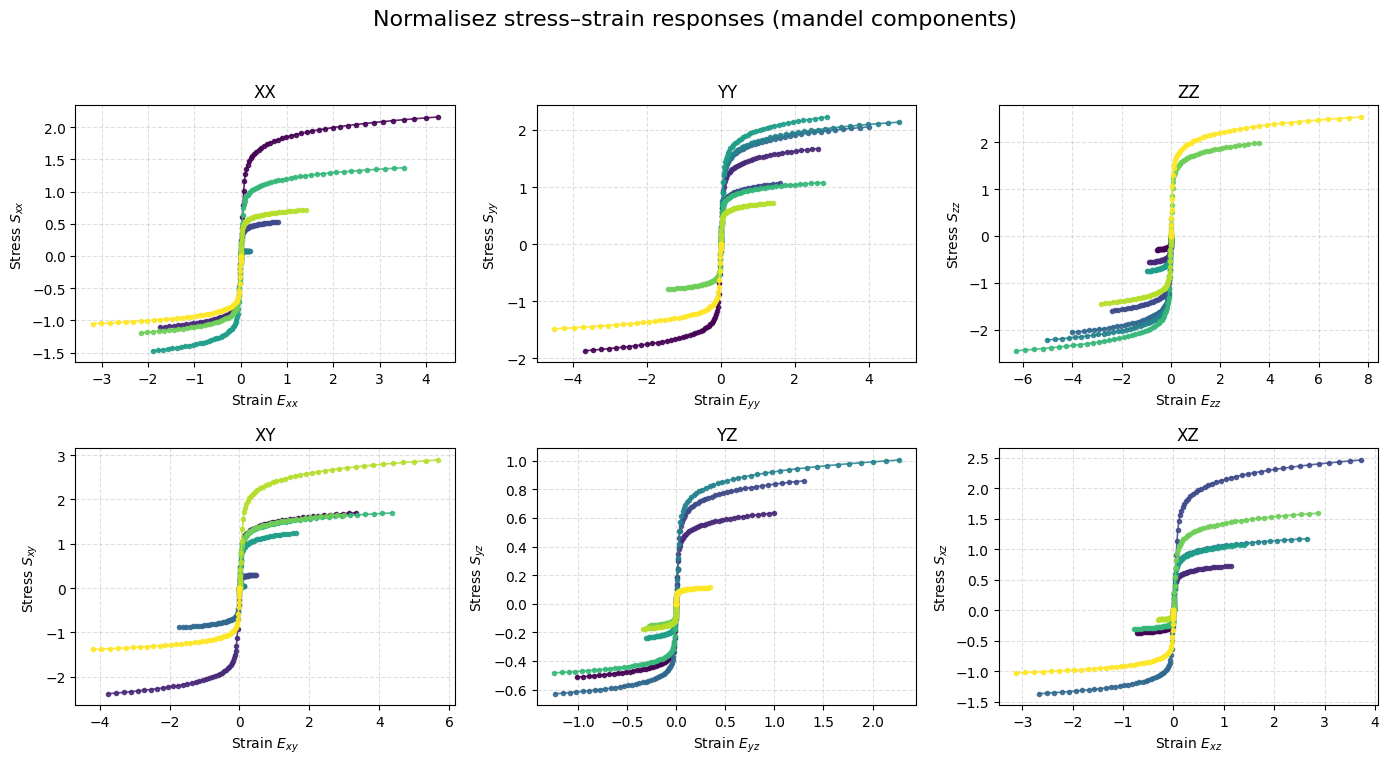

In [52]:
import numpy as np
import matplotlib.pyplot as plt

components = [
    ("XX", r"$E_{xx}$", r"$S_{xx}$"),
    ("YY", r"$E_{yy}$", r"$S_{yy}$"),
    ("ZZ", r"$E_{zz}$", r"$S_{zz}$"),
    ("XY", r"$E_{xy}$", r"$S_{xy}$"),
    ("YZ", r"$E_{yz}$", r"$S_{yz}$"),
    ("XZ", r"$E_{xz}$", r"$S_{xz}$"),
]

n_paths = min(10, strain.shape[0])
colors = plt.cm.viridis(np.linspace(0, 1, n_paths))

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)

for k, (name, eps_label, sig_label) in enumerate(components):
    ax = axes.flat[k]

    for i in range(n_paths):
        ax.plot(
            strain[i, :, k],
            stress[i, :, k],
            color=colors[i],
            marker='o',
            markersize=3,
            linewidth=1.2,
            alpha=0.85
        )

    ax.set_xlabel(f"Strain {eps_label}")
    ax.set_ylabel(f"Stress {sig_label}")
    ax.set_title(name)
    ax.grid(True, linestyle="--", alpha=0.4)

fig.suptitle("Normalisez stress–strain responses (mandel components)", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [53]:
jnp.mean(strain), jnp.std(strain)

(Array(0.00225855, dtype=float64), Array(1.00034418, dtype=float64))

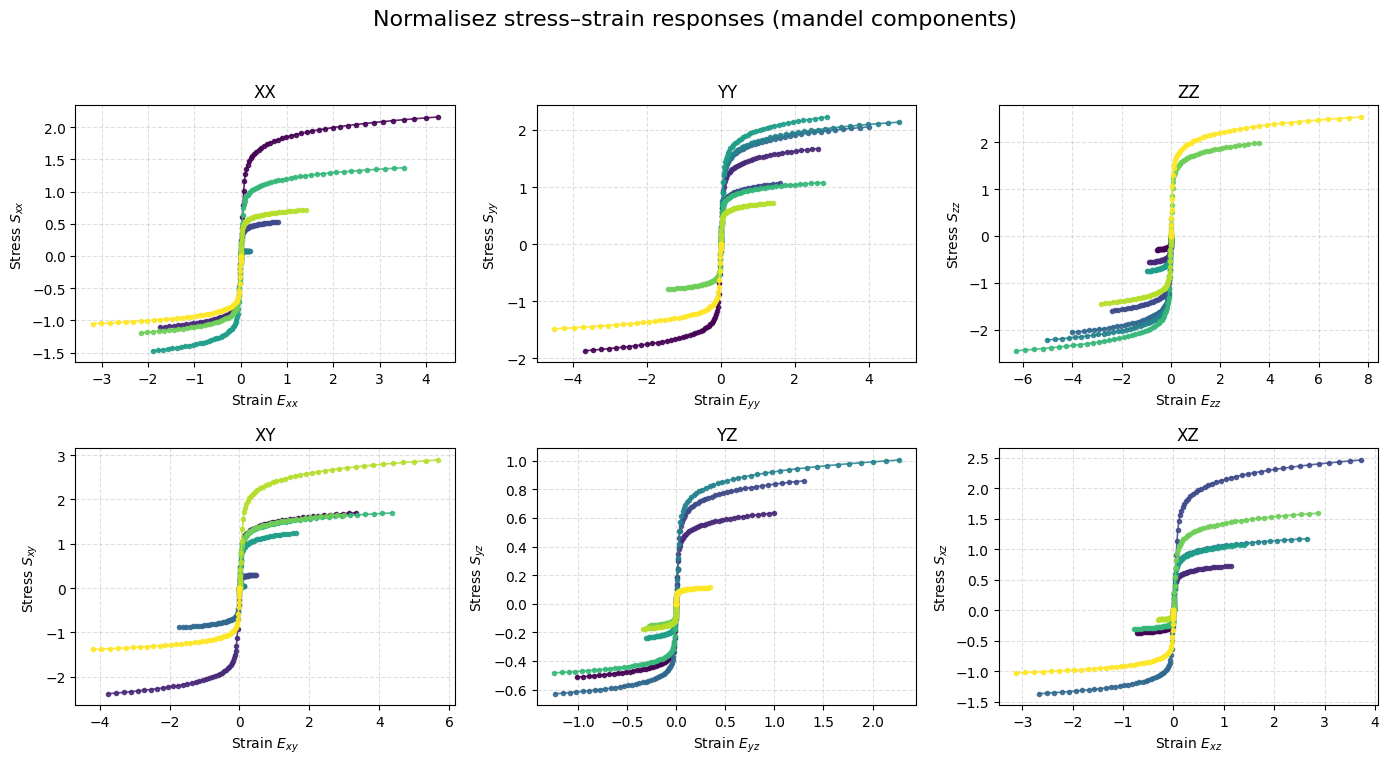

In [54]:
import numpy as np
import matplotlib.pyplot as plt

components = [
    ("XX", r"$E_{xx}$", r"$S_{xx}$"),
    ("YY", r"$E_{yy}$", r"$S_{yy}$"),
    ("ZZ", r"$E_{zz}$", r"$S_{zz}$"),
    ("XY", r"$E_{xy}$", r"$S_{xy}$"),
    ("YZ", r"$E_{yz}$", r"$S_{yz}$"),
    ("XZ", r"$E_{xz}$", r"$S_{xz}$"),
]

n_paths = min(10, strain.shape[0])
colors = plt.cm.viridis(np.linspace(0, 1, n_paths))

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)

for k, (name, eps_label, sig_label) in enumerate(components):
    ax = axes.flat[k]

    for i in range(n_paths):
        ax.plot(
            strain[i, :, k],
            stress[i, :, k],
            color=colors[i],
            marker='o',
            markersize=3,
            linewidth=1.2,
            alpha=0.85
        )

    ax.set_xlabel(f"Strain {eps_label}")
    ax.set_ylabel(f"Stress {sig_label}")
    ax.set_title(name)
    ax.grid(True, linestyle="--", alpha=0.4)

fig.suptitle("Normalisez stress–strain responses (mandel components)", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

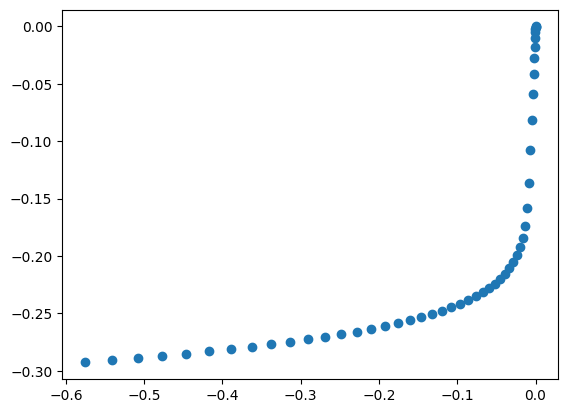

In [55]:
i = 0
plt.scatter(strain[i,:,2], stress[i,:,2])#+ 0.03 * jax.random.normal(key, shape=stress[i,:,5].shape))

# Define the model

The neural network will be defined to predict the elastic potential such as $\sigma = \frac{\partial \Psi}{\partial \varepsilon}$.

We devide the potential into two contribution, first a linear elastic isotropic contribution : 

$$
\Psi_{\text{lin}}(\bm  \varepsilon) = \dfrac{1}{2}\bm  \varepsilon:\mathbb C_0:\bm  \varepsilon 
$$

Where $\mathbb C_0$ is an isotropic elastic stiffness tensor, where $E, \nu$ have to be determined during the training.

Then, we define a non-linear contribution $\Psi_{\text{nl}}$ which is directly function of the equivale

And a non-linear contribution which is depend to the equivalent von mises strain such as : 

$$
\Psi_{\text{nl}}(\varepsilon_{\text{eq}}) = \mathcal N_{\text{NL}}(\bm \varepsilon_{\text{eq}}).
$$

such as $\Psi(\bm  \varepsilon) = \Psi_{\text{lin}}(\bm  \varepsilon) + \Psi_{\text{nl}}(\bm \varepsilon_{\text{eq}})$.

In [56]:
# class FreeEnergy(eqx.Module):
#     linear: jm.AbstractLinearElastic
#     nlinear: MLP

#     def potential(self, epsilon):
#         s = epsilon - jnp.trace(epsilon)/3 * jnp.eye(3)
#         J2 = 2./3. * jnp.sum(s * s)
#         x = jnp.reshape(J2, (1,))
#         return self.nlinear(x)[0]
#     def __call__(self, epsilon):
#         psi_el = 0.5 * jnp.trace(epsilon @ (self.linear.C @ epsilon))
#         return self.potential(epsilon) + psi_el
#     def stress(self,epsilon):
#         return jax.jacrev(self.__call__)(epsilon)
    
#     def tangent_operator(self, epsilon):
#         return jax.jacrev(self.stress)(epsilon)
    
class FreeEnergy(eqx.Module):
    linear: jm.AbstractLinearElastic
    nlinear: ICNN


    def potential(self, epsilon):
        # s = epsilon - jnp.trace(epsilon)/3 * jnp.eye(3)
        # J2 = 2./3. * jnp.sum(s * s)
        # x = jnp.reshape(J2, (1,))
        x = jnp.sum(epsilon * epsilon)
        return self.nlinear(x)
    def __call__(self, epsilon):
        psi_el = 0.5 * jnp.trace(epsilon @ (self.linear.C @ epsilon))
        epsilon_ = epsilon._tensor
        return self.potential(epsilon_) #+ psi_el# - jax.jvp(self.potential,(jnp.zeros_like(epsilon_),),(epsilon_,))[1]) + psi_el
    def stress(self,epsilon):
        return jax.jacrev(self.__call__)(epsilon)
    
    def tangent_operator(self, epsilon):
        return jax.jacrev(self.stress)(epsilon)

In [57]:
linear = jm.LinearElasticIsotropic(200.0e9 * jnp.mean(scalers["std_strain"]) / jnp.mean(scalers["std_stress"]), 0.3)
mlp = MLP(key=key, in_size=1,out_size=1, width_size=64, depth=4,activation=jax.nn.softplus)
icnn = ICNN(1, [8,8], key)
# nn = FreeEnergy(linear, mlp)
# scale = jnp.array(1e-5)
nn = FreeEnergy(linear, icnn)

In [58]:
epsilon_train = SymmetricTensor2.from_mandel(strain.reshape(-1, 6))
stress_train = SymmetricTensor2.from_mandel(stress.reshape(-1, 6))
epsilon_test = SymmetricTensor2.from_mandel(strain_test.reshape(-1, 6))
sig_test = SymmetricTensor2.from_mandel(stress_test.reshape(-1, 6))

In [44]:
sig_noise = SymmetricTensor2(tensor=stress_train) #+ 0.03 * jax.random.normal(key, shape=stress_train.tensor.shape)
sig_val   = SymmetricTensor2(tensor=sig_test)

learning_rate = 1e-2
max_steps =3000
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_param_block_rms(),
    optax.scale(-learning_rate),
)

# --- Loss function ---
@eqx.filter_jit
def loss_fn(params, args):
    sig_data,epsilon_train, static_ = args
    material_ = params if static_ is None else eqx.combine(params, static_)
    sig_hat = jax.vmap(material_.stress)(epsilon_train)
    diff = sig_hat.tensor - sig_data.tensor
    loss_val = 0.5 * jnp.mean(diff**2)
    return loss_val, sig_hat

# --- Gradient step ---
@eqx.filter_jit
def step(params, opt_state, args):
    (loss_val, sig_hat), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, args)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val, sig_hat

@eqx.filter_jit
def eval_step(params, args):
    loss_val, sig_hat = loss_fn(params, args)
    return loss_val, sig_hat

trainable, static = partition_by_node_names(nn, ["linear"])
# trainable, static = eqx.partition(nn, eqx.is_array)

# initialisation optimizer
params = trainable
opt_state = optimizer.init(params)

# Training loop
for step_idx in range(max_steps):
    params, opt_state, loss_train, sig_hat_train = step(params, opt_state, (sig_noise,epsilon_train, static))

    if step_idx % 200 == 0:
        loss_val, sig_hat_val = eval_step(
            params, (sig_val, epsilon_test, static)
        )

        print(
            f"Step {step_idx:5d} | "
            f"train = {float(loss_train):.6e} | "
            f"val = {float(loss_val):.6e}"
        )

# Combiner trainable + static pour obtenir le matériau complet
trained_material = params if static is None else eqx.combine(params, static)


Step     0 | train = 3.247905e+02 | val = 1.846822e+02
Step   200 | train = 9.039231e+01 | val = 5.166917e+01
Step   400 | train = 7.853913e+01 | val = 4.516986e+01
Step   600 | train = 7.736391e+01 | val = 4.488219e+01
Step   800 | train = 7.720797e+01 | val = 4.488217e+01
Step  1000 | train = 7.719606e+01 | val = 4.488217e+01
Step  1200 | train = 7.719231e+01 | val = 4.488217e+01
Step  1400 | train = 7.719132e+01 | val = 4.488217e+01
Step  1600 | train = 7.719098e+01 | val = 4.488217e+01
Step  1800 | train = 7.719083e+01 | val = 4.488217e+01
Step  2000 | train = 7.719074e+01 | val = 4.488217e+01
Step  2200 | train = 7.719068e+01 | val = 4.488217e+01
Step  2400 | train = 7.719064e+01 | val = 4.488217e+01
Step  2600 | train = 7.719062e+01 | val = 4.488217e+01
Step  2800 | train = 7.719060e+01 | val = 4.488217e+01


In [45]:
nn

FreeEnergy(
  linear=LinearElasticIsotropic(E=f64[], nu=f64[]),
  nlinear=ICNN(
    Ws=[f64[8,1], f64[8,8]], bs=[weak_f64[8], weak_f64[8]], final_W=f64[8]
  )
)

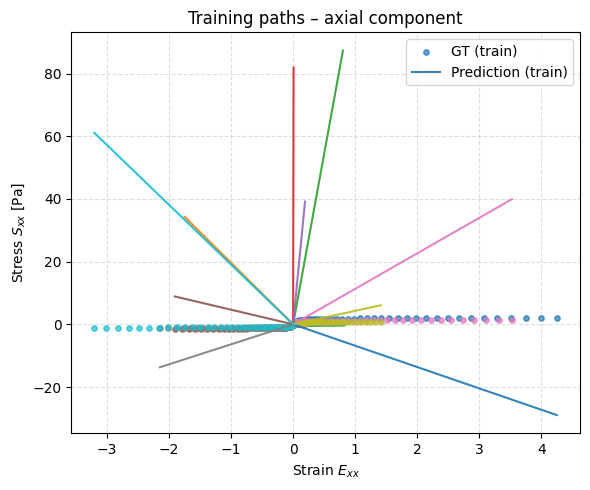

: 

In [ ]:
sig_hat_test = jax.vmap(trained_material.stress)(epsilon_test)
eps_train = epsilon_train._tensor.reshape(-1, 50, 3, 3)
eps_test = epsilon_test._tensor.reshape(-1, 50, 3, 3)
sig_hat_test_ = jax.vmap(trained_material.stress)(epsilon_test)._tensor.reshape(-1, 50, 3, 3) #sig_hat_test._tensor.reshape(-1, 50, 3, 3)
sig_hat_train_ = sig_hat_train._tensor.reshape(-1, 50, 3, 3)
stress_train_ = stress_train._tensor.reshape(-1, 50, 3, 3)
# stress_test_ = stress_test._tensor.reshape(-1, 50, 3, 3)


n_paths = 10

fig, ax = plt.subplots(figsize=(6, 5))
for i in range(n_paths):
    color = f"C{i}"  # même couleur pour GT et prédiction

    # Ground truth (train) — scatter
    ax.scatter(
        eps_train[i, :, 0, 0],
        stress_train_[i, :, 0, 0],
        s=15,
        alpha=0.7,
        color=color,
        label="GT (train)" if i == 0 else None
    )

    # Model prediction (train) — line
    ax.plot(
        eps_train[i, :, 0, 0],
        sig_hat_train_[i, :, 0, 0],
        linewidth=1.5,
        alpha=0.9,
        color=color,
        label="Prediction (train)" if i == 0 else None
    )

ax.set_xlabel(r"Strain $E_{xx}$")
ax.set_ylabel(r"Stress $S_{xx}$ [Pa]")
ax.set_title("Training paths – axial component")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

# Conversion and export 

We got a trained model, we want now to use it inside MFront. MFront got the advantage to directly integrate cpp codes. However, there is now JAX cpp API. 
Nevertheless, Jax Pytree models can easily convert to Tensorflow models thanks to the package [jax2tf](https://github.com/jax-ml/jax/blob/main/jax/experimental/jax2tf/README.md).

To do so, we need to define the functions we want to convert. We integrate inside the scaling, and the tangent operator is directly computed.

In [10]:
def stress_fn(epsilon:jnp.array):
    '''function that take the 6 composant of epsilon in mandel notation. Return the strain in mandel notation.'''
    epsilon /= jnp.mean(scalers["std_strain"])#
    epsilon_ = SymmetricTensor2.from_mandel(epsilon)
    return trained_material.stress(epsilon_).to_mandel() * jnp.mean(scalers["std_stress"])

def tangentop_fn(epsilon:jnp.array):
    '''function that take the 6 composant of epsilon in mandel notation. Return a 6x6 tensor.'''
    C = jax.jacfwd(stress_fn)(epsilon)
    return C

We then define a tensorflow model with the two functions.

In [11]:
from jax.experimental import jax2tf
import tensorflow as tf
# Conversion JAX → TF
stress_tf = tf.function(jax2tf.convert(stress_fn, with_gradient=False, enable_xla=False), 
                        input_signature=[
        tf.TensorSpec(shape=(6,), dtype=tf.float64, name="epsilon"),
    ],)
tangentop_tf = tf.function(jax2tf.convert(tangentop_fn, with_gradient=False, enable_xla=False), 
                    input_signature=[
        tf.TensorSpec(shape=(6,), dtype=tf.float64, name="epsilon"),
    ],)

class ConstitutiveModel(tf.Module):
    def __init__(self):
        super().__init__()
        self.stress = stress_tf
        self.tangentop = tangentop_tf

model = ConstitutiveModel()

2026-01-22 09:46:17.280914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-22 09:46:17.280958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-22 09:46:17.282181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-22 09:46:18.129631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
# test fonction : 
x = np.zeros((100, 6))
exy = np.linspace(0, 0.02, 100)
x[:,3] = exy

stress  = np.array([stress_tf(xi) for xi in x])

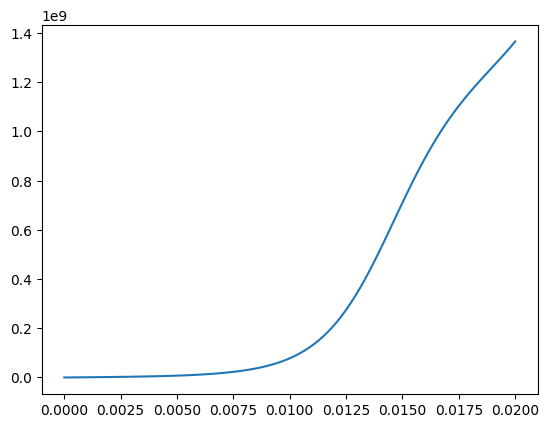

: 

In [ ]:
plt.plot(exy, stress[:,3])

Then the model is saved in the SavedModel format, a language-neutral serialization format. The model is defined in the folder `./nl-model`

In [ ]:
import numpy as np
eps = np.random.rand(6)
stress_res = model.stress(eps)
tangentop_res = model.tangentop(eps)
print("stress: ", stress_res)
print("tangent: ", tangentop_res)

tf.saved_model.save(
    model,
    export_dir="./nl_model",
    signatures={
        "stress": model.stress,
        "tangentop": model.tangentop,
    }
)